# Лабораторная 2: Композиции

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам − проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Задания, признанные преподавателями плагиатом, будут оценены нулем баллов и понижают карму (подробнее о плагиате см. на странице курса).

## Подготовка данных

Изучите [датасет](http://archive.ics.uci.edu/ml/datasets/BlogFeedback). Каждый объект $-$ пост в блоге. Он описывается различными признаками: длина текста поста, наличие наиболее частотных слов, день недели, количество комментариев за последние 24 часа и т.п., а так же целевым признаком - количеством комментариев к посту. Полный список признаков и описание находятся на странице датасета. Вам предлагается решать задачу регресии, используя метрику качества [MSE](https://en.wikipedia.org/wiki/Mean_squared_error).


![](http://i.imgur.com/zE95i7e.png)

Загрузите датасет и произвольно разбейте данные из файла **blogData_train.csv** на обучающую и тестовую выборки в пропорциях 1 к 4 соответственно. Обратите внимание, что обучающая выборка меньше тестовой. Такая большая тестовая выборка позволит сделать измерения качества моделей достаточно достоверным.

In [14]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict

%matplotlib inline

In [79]:
data = pd.read_csv('./blogData_train.csv', names=[f'f{i}' for i in range(280)] + ['target'])
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [80]:
X_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279
15863,53.383335,37.399086,0.0,165.0,49.0,22.383333,22.124464,0.0,110.0,15.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13936,34.589355,98.559500,0.0,713.0,2.0,14.205323,55.165180,0.0,596.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7939,16.593575,19.671364,1.0,144.0,10.0,6.512450,11.051215,0.0,111.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16105,27.230215,45.970950,0.0,371.0,14.0,10.784173,24.209942,0.0,228.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46261,9.080925,11.228800,0.0,97.0,6.0,3.641618,6.549403,0.0,97.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
y_train.head()

15863    61.0
13936     1.0
7939      0.0
16105     2.0
46261     5.0
Name: target, dtype: float64

## Bias-Variance decomposition

![](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

Исследуем bias-variance разложение (см. слайды 9–13 из [второй лекции](https://www.dropbox.com/s/sofa55wzmsyszsq/slides-Composition-shad-2.pdf?dl=0)) для решающих деревьев различной глубины. К сожалению, на реальных данных невозможно вычислять матожидания по всевозможным обучающим выборкам, которые необходимы в формуле bias-variance разложения. Поэтому мы проведем приближенный численный эксперимент с эмпирическими оценками этих матожиданий.

Обозначим вектор истинных меток тестовой выборки за $\ f$. С помощью бутстраппинга можно просемплировать из обучающей выборки $N$ новых обучающих выборок того же размера, тем самым "имитируя" пространство всевозможных обучающих выборок. На каждой такой выборке можно обучить решающее дерево. Векторы прогнозов решающих деревьев для объектов из тестовой выборки обозначим за $y_i, i \in \{1, .., N\}$. Тогда средний квадрат ошибки по всем моделям на тестовой выборке можно записать как $$error=\frac{1}{N}\sum_{i=1}^{N}MSE(f,y_i).$$

Обозначим среднее предсказание моделей как $$\overline y = \frac{1}{N}\sum_{i=1}^{N} y_i.$$

Тогда квадрат отклонения среднего предсказания всех моделей на тестовой выборке от истинных меток запишется как $$bias^2 = MSE(f, \overline y).$$

Также разброс прогнозов относительно среднего предсказания запишется следующим образом: $$variance = \frac{1}{N}\sum_{i=1}^N MSE(y_i, \overline y).$$




#### Задание 1 (0.5 балла)
Постройте графики зависимости $error$, $bias^2$ и $variance$ от глубины решающего дерева (от 1 до 15 включительно)  для $N=100$. Являются ли какие-то из полученных графиков монотонными? А должны ли они быть монотонными, если бы гипотетически эксперименты были проведены на всевозможных выборках? Почему? Убедитесь численно, что верно bias-variance разложение ошибки: $$error = bias^2 + variance.$$

(Подсказка: для сэмплирования можно воспользоваться [BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html))

In [23]:
def bias_variance_decomposition(get_regressor, parameters):
    errors = []
    bias2s = []
    variances = []
    for i in tqdm(parameters):
        regressor = BaggingRegressor(get_regressor(i), n_estimators=100, n_jobs=-1)
        regressor.fit(X_train, y_train)

        predictions = [clf.predict(X_test) for clf in regressor.estimators_]
        y_mean = np.mean(predictions, axis=0)

        error = np.mean([mean_squared_error(y_test, pred) for pred in predictions])
        bias2 = mean_squared_error(y_test, y_mean)
        variance = np.mean([mean_squared_error(pred, y_mean) for pred in predictions])

        errors.append(error)
        bias2s.append(bias2)
        variances.append(variance)
    
    return errors, bias2s, variances

def print_bias_variance_decomposition(xs, errors, bias2s, variances):
    plt.figure()
    plt.xlabel('max_depth')
    plt.ylabel('')
    plt.plot(xs, errors, label="MSE")
    plt.plot(xs, bias2s, label="$bias^2$")
    plt.plot(xs, variances, label="Variance")
    plt.legend()

In [24]:
xs = list(range(1, 16))
errors, bias2s, variances = bias_variance_decomposition(lambda i: DecisionTreeRegressor(max_depth=i), xs)

A Jupyter Widget

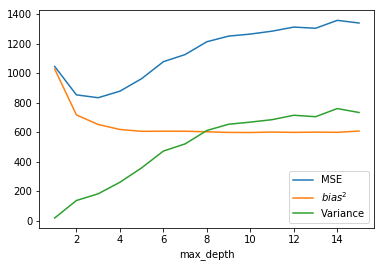

In [25]:
print_bias_variance_decomposition(xs, errors, bias2s, variances)

На графике почти монотонны $bias^2$ и Variance, так как с увеличением глубины дерева, модель сильнее подстраивается под обучающую выборку

In [26]:
pd.DataFrame.from_dict({'max_depth': xs, 'error': errors, 'bias2+variance': np.array(bias2s) + np.array(variances)})

,bias2+variance,error,max_depth
0,1045.947880,1045.947880,1
1,853.057897,853.057897,2
2,833.501568,833.501568,3
3,877.901427,877.901427,4
4,962.960729,962.960729,5
5,1077.893532,1077.893532,6
6,1126.538539,1126.538539,7
7,1213.412631,1213.412631,8
8,1251.624051,1251.624051,9
9,1265.487998,1265.487998,10


По таблице видно, что bias-variance разложение ошибки верно

## Композиции алгоритмов

Несмотря на описанный выше недостаток решающих деревьев, объединение их в композиции позволяет существенно улучшить качество предсказания. Рассмотрим несколько способов построения композиций.

![](http://i.imgur.com/XztXz7n.png?)

### Bagging + RSM vs RandomForest

![](https://sites.google.com/site/rajhansgondane2506/_/rsrc/1467898300734/publications/rrftrain.jpg?height=215&width=320)

Один из способов объединения алгоритмов в композиции — обучение каждого отдельного алгоритма на некоторой подвыборке из исходной выборки ([bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating)) и подмножестве исходных признаков ([RSM](https://en.wikipedia.org/wiki/Random_subspace_method)). В sklearn этот тип композиции реализован в классе [BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) (для случая регресии) и в классе [BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) (для случая классификации) . Подобный подход также есть в реализации [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) и [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

#### Задание 2 (0.5 балла) 
Обучите Random Forest. Постройте и сравните графики зависимости качества прогноза от количества базовых алгоритмов:
  - на обучающей выборке,
  - на тестовой выборке,
  - используя ошибку Out-of-Bag.

In [12]:
xs = list(map(int, np.linspace(5, 200, 20)))

In [6]:
mses_train = []
mses_test = []
mses_oob = []
for i in tqdm(xs):
    clf = RandomForestRegressor(n_estimators=i, oob_score=True)
    clf.fit(X_train, y_train)
    mses_train.append(mean_squared_error(y_train, clf.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, clf.predict(X_test)))
    mses_oob.append(mean_squared_error(y_train, clf.oob_prediction_))

A Jupyter Widget

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


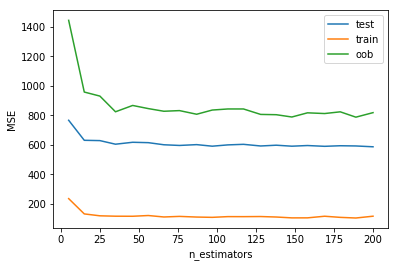

In [13]:
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.plot(xs, mses_test, label='test')
plt.plot(xs, mses_train, label='train')
plt.plot(xs, mses_oob, label='oob')
plt.legend()

Видно, что уже после 50 деревьев качество прогноза сильно не улучшается

#### Задание 3 (0.5 балла)
Проведите аналогичный эксперимент с bias-variance разложением для RandomForest, для количества алгоритмов 1, 5, 10, 25 и 50. Отличаются ли графики от аналогичных графиков для решающих деревьев? На какую компоненту из разложения ошибки влияет объединение алгоритмов в рассмотренный тип композиции? Поясните свой ответ.

In [27]:
xs = [1, 5, 10, 25, 50]
errors, bias2s, variances = bias_variance_decomposition(lambda i: RandomForestRegressor(n_estimators=i), xs)

A Jupyter Widget

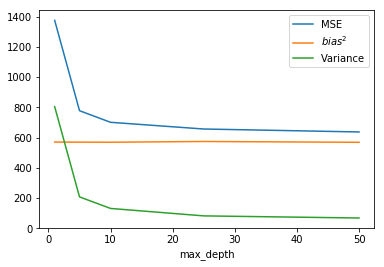

In [28]:
print_bias_variance_decomposition(xs, errors, bias2s, variances)

Видно, что увеличение количества деревьев не влияет на $bias^2$. В отличие от решающих деревьев, с увеличением числа деревьев в RF заметно уменьшается variance-компонента, это происходит из-за того, что мы усредняем ответы множества деревьев

#### Задание 4 (1 балл)
Обучите Random Forest и композицию деревьев, построенную с помощью техник Bagging и RSM на решающих деревьях, до тех пор, пока качество на обучении не стабилизируется, подобрав оптимальные параметры сабсемлинга по объектам и признаками для каждого метода. Постройте и сравните графики зависимости качества прогнозов этих двух композиций от количества базовых алгоритмов.

Какой алгоритм предсказывает лучше?

### Градиентный бустинг

В случае бустинга композиция алгоритмов строится последовательно. Каждый следующий базовый алгоритм акцентируется на тех объектах, на которых обученная ранее композиция допускала ошибку.

На данный момент одной из самых широко распространенных реализаций бустинга является библиотека [XGBoost](https://github.com/dmlc/xgboost). В ней большое внимание уделяется регуляризации и скорости, нежели в других реализациях бустинга (например,  [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html),  [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) из sklearn). Кроме того, XGBoost позволяет оптимизировать различные функции потерь, а также более гибок, засчет большого числа параметров.

XGBoost строит композицию из $K$ базовых алгоритмов $b_k$:

$$ \hat{y}_i = \hat{y}_i^{K} = \sum_{k=1}^{K} b_k(x_i) = \hat{y}_i^{\left(K - 1\right)} + b_K(x_i), $$

минимизируя следующий функционал:

$$ Obj = \sum_{i=1}^N \mathcal{L}(y_i, \hat{y}_i ) + \sum_{k=1}^{K} \Omega(b_k),$$

где
 - $N$ — размер обучающей выборки;
 - $x_i, y_i, \hat{y}_i$ — i-ый объект, правильный ответ и предсказание модели для него;
 - $\hat{y}_i^{t}$ — предсказание композиции из $t$ уже обученных базовых алгоритмов для i-го объекта;
 - $\Omega$ — регуляризатор;
 - $\mathcal{L}(y_i, \hat{y}_i)$ — функция потерь.

Функционал, оптимизируемый на $t$-ой итерации:

$$ Obj^{(t)} = \sum_{i=1}^N \mathcal{L}\left(y_i, \hat{y}_i^{(t-1)} + b_t(x_i)\right) + \Omega(b_t).$$

В XGBoost реализовано несколько различных функций потерь, что позволяет решать задачи классификации (бинарной и мультиклассовой), регрессии и ранжирования. Вот некоторые из них:

- reg:linear — линейная регрессия
- reg:logistic — логистическая регрессия
- binary:logistic — логистическая регрессия
- multi:softmax — softmax функция потерь для многоклассовой классификации
- rank:pairwise — минимизация pairwise-функции потерь для задачи ранжирования

#### Задание 5 (1 балл)
Обучите градиентый бустинг над 100 деревьями с одинаковыми параметрами, используя библиотеки scikit-learn и xgboost. Сравните получившиеся композиции, построив графики качества на обучающей и тестовой выборке в зависимости от количества деревьев. В дальнейших экспериментах используйте реализацию бустинга XGBoost. Если бустинг из sklearn показывает лучшие результаты, попробуйте потюнить те параметры, которые есть только у XGBoost но нет у бустинга sklearn.

In [100]:
def get_mses(get_regressor, xs):
    mses_train = []
    mses_test = []
    for x in tqdm(xs):
        reg = get_regressor(x)
        reg.fit(X_train, y_train)
        mses_train.append(mean_squared_error(y_train, reg.predict(X_train)))
        mses_test.append(mean_squared_error(y_test, reg.predict(X_test)))
    return mses_train, mses_test

In [101]:
xs = list(map(int, np.linspace(10, 100, 20)))

In [102]:
gb1_mses_train, gb1_mese_test = get_mses(lambda i: GradientBoostingRegressor(n_estimators=i), xs)

A Jupyter Widget

In [103]:
gb2_mses_train, gb2_mese_test = get_mses(lambda i: xgb.XGBRegressor(n_estimators=i), xs)

A Jupyter Widget

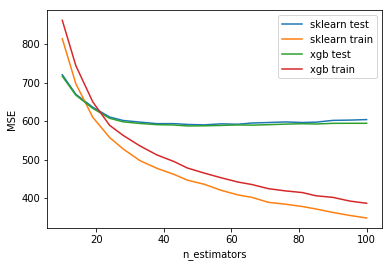

In [104]:
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.plot(xs, gb1_mese_test, label='sklearn test')
plt.plot(xs, gb1_mses_train, label='sklearn train')
plt.plot(xs, gb2_mese_test, label='xgb test')
plt.plot(xs, gb2_mses_train, label='xgb train')
plt.legend()

Видно, что GradientBoostingRegressor выдает качество лучше на train, но немного хуже на test, пробовал потюнить параметры, но лучше на трейне xgboost вести себя не стал.

#### Задание 6 (0.5 балла)
Проведите аналогичный эксперимент с bias-variance разложением для градиентного бустинга XGBoost для количество алгоритмов 1, 5, 10, 25 и 50, используя в качестве базовых алгоритмов решающие деревья. Обратите внимание, что данная библиотека имеет два интерфейса (стандартный и аналог sklearn), названия параметров в которых могут отличаться.
Отличаются ли графики от аналогичных графиков для решающих деревьев и RandomForest? На какую компоненту из разложения ошибки влияет объединение алгоритмов в рассмотренный тип композиции? Поясните свой ответ.

In [54]:
xs = [1, 5, 10, 25, 50]
errors, bias2s, variances = bias_variance_decomposition(lambda i: xgb.XGBRegressor(n_estimators=i), xs)

A Jupyter Widget

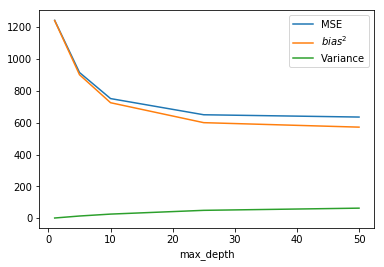

In [55]:
print_bias_variance_decomposition(xs, errors, bias2s, variances)

Видно, что при бустинге ошибка уменьшается в основном за счет уменьшения $bias^2$, variance-компонента при этом почти не меняется.

#### Задание 7 (0.5 балла)
Сравните лучшую композицию из задания 4 с обоими бустингами из задания 5 по следующим параметрам:
  - время обучения в зависимости от количества деревьев,
  - качество предсказания на тестовой выборке в зависимости от количества деревьев.

#### Задание 8 (0.5 балла)
Используйте лучшую композицию из задания 4 в качестве начального приближения для градиентного бустинга над деревьями, т.е. обучайте бустинг на ошибки, которые дает композиция. Аналогичную операцию проделайте для начального приближения линейной регрессией. Дали ли подобные подходы прирост качества по сравнению с обычным градиентным бустингом и почему?

#### Задание 9 (0.5 балла)
Обучите линейную регрессию (LR), Random Forest (RF) и градиентный бустинг XGBoost (GBDT, в двух вариациях: обычный и такой, как в задании 8). Подберите оптимальные $\alpha$ для алгоритмов $\alpha \cdot RF + (1 - \alpha) \cdot GBDT$ и $\alpha \cdot LR + (1 - \alpha) \cdot GBDT$. Сравните качество новых моделей между собой и моделями из предыдущих заданий.

### Стекинг
![](https://4.bp.blogspot.com/-hCxAb57kzDQ/VuMgHy3hAhI/AAAAAAAAAVk/djmL9IHv5QkLWeudjE50qDoCTbiUrTetA/s1600/Stacking.jpg)

[Stacking](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking) — еще один способ объединить несколько алгоритмов в один, который часто используется как в решении реальных задач из промышленной сферы, так и в конкурсах на платформах вроде Kaggle. Подход использует понятие *базовых классификаторов*, каждый из которых независимо обучается на некотором (возможно одном и том же) множестве признаков, а также *мета-классификатора*, использующего предсказания базовых классификаторов как факторы. 

Загрузите [датасет](https://archive.ics.uci.edu/ml/datasets/covertype). В тренировочных целях предлагается вместо задачи мультиклассификации решать задачу обычной бинарной классификации — научиться отличать **Spruce-Fir** (значение целевой переменной — 1) от **Lodgepole Pine** (значение целевой переменной — 2). Разделите выборку на обучение и тест в соотношении 50/50. В качестве метрики используйте [accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [7]:
data = pd.read_csv('./covtype.data', names=[f'f{i}' for i in range(54)] + ['target'])
data = data[(data.target == 1) | (data.target == 2)]
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [8]:
X_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53
413611,3187,23,14,150,33,3288,211,209,131,782,...,0,1,0,0,0,0,0,0,0,0
508180,2912,70,13,564,161,1358,233,214,111,1597,...,0,1,0,0,0,0,0,0,0,0
523245,2961,245,23,192,61,3139,166,250,216,1952,...,0,0,0,0,0,0,0,0,0,0
274604,2930,307,23,108,35,767,152,220,205,2663,...,0,0,0,0,0,0,0,0,0,0
69784,2932,39,9,390,19,4115,221,220,134,5850,...,0,0,0,0,0,0,0,0,0,0


In [9]:
y_train.head()

413611    1
508180    2
523245    2
274604    1
69784     2
Name: target, dtype: int64

#### Задание 10 (1 балл) 
Использование мета-классификатора подразумевает получение предсказаний от базовых классификаторов для тех объектов обучающей выборки, на которых мета-классификатор будет обучаться. В свою очередь базовые классификаторы тоже должны быть обучены на некоторой выборке. Чтобы избежать переобучения, обучающее множество делится на $n$ фолдов, $(n-1)$ из которых используются для обучения базовых классификаторов, а $n$-ый — для предсказания (вычисления мета-фактора).

Для получения мета-факторов для тестовых данных базовые классификаторы могут быть обучены на всем обучающем множестве, поскольку проблема переобучения здесь не возникает. Другими словами, если мы хотим посчитать факторы для тестового множества, мы можем спокойно использовать обучающее множество для тренировки базовых классификаторов. Если же мы хотим посчитать факторы для обучающего множества, то необходимо следить, чтобы классификатор не предсказывал для тех объектов, на которых обучался.

Мета-классификатор может быть обучен как на множестве исходных факторов, дополненным мета-факторами, так и исключительно на множестве мета-факторов. Выбор зависит от решаемой задачи.

Напишите функцию, которая получает на вход классификатор, обучающую и тестовые выборки, а также параметры [кросс-валидатора](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) и возвращающую значения мета-фактора для обучающего и тестового множеств

In [10]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv, *args, **kwargs):
    train_meta = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')
    test_meta = clf.fit(X_train, y_train).predict_proba(X_test)
    return train_meta, test_meta

#### Задание 11 (2 балла)
Поэкспериментируйте со стекингом, ответьте на вопросы и обоснуйте наблюдения:
Обучите различные известные вам модели машинного обучения и сделайте из них стекинг-композицию (да-да, каждый моежт сделать свою уникальную композицию, с любыми алгоритмами). 

построийте несколько композиций, руководствуясь тем, что базовые алгоритмы могут отличаться друг от друга:
  - моделью машинного обучения;
  - гиперпараметрами (например, различные функции потерь или глубины деревьев);
  - набором фич (можно случайно сэмплировать фичи, а можно фиксировано разбить фичи на группы);
  - различными обучающими выборками (можно случайно сэмплировать объекты обучающей выборки, а можно фиксированно побить на группы);
  - типом модели: для данной задачи можно использовать как классификаторы, так и регрессоры.
  
Обратите внимание, что бинарные мета-факторы дают меньше полезного сигнала мета-классификатору, чем числовые, поэтому базовым классификаторам лучше возвращать вероятность/числовую функцию, чем метки классов.
  
Обучите мета-классификатор на различных наборах факторов:
  - исходные факторы;
  - исходные факторы + мета-факторы;
  - мета-факторы.

  
Имеет ли смысл добавлять исходные факторы в мета-классификатор, если базовые классификаторы уже обучены на этом наборе? Удается ли добиться улучшения качества за счет стекинга? Какие классификаторы лучше сочетаются друг с другом в такой композиции?

Попробуйте разные размеры фолда при подсчете мета-факторов. Влияет ли размер на качество?

Попробуем обучать 3 классификатора на всех фичах:

In [43]:
X_train_log, X_test_log = compute_meta_feature(LogisticRegression(), X_train, X_test, y_train, 5)
accuracy_score(y_test, X_test_log.argmax(axis=1) + 1)

0.7727197450428362

In [44]:
X_train_tree, X_test_tree = compute_meta_feature(DecisionTreeClassifier(), X_train, X_test, y_train, 5)
accuracy_score(y_test, X_test_tree.argmax(axis=1) + 1)

0.9381470366076802

In [45]:
X_train_rf, X_test_rf = compute_meta_feature(RandomForestClassifier(), X_train, X_test, y_train, 5)
accuracy_score(y_test, X_test_rf.argmax(axis=1) + 1)

0.9413380404005316

In [46]:
clf = LogisticRegression()

clf.fit(np.hstack((
    X_train_log,
    X_train_tree,
    X_train_rf
)), y_train)

final_prediction = clf.predict(np.hstack((
    X_test_log,
    X_test_tree,
    X_test_rf
)))

accuracy_score(y_test, final_prediction)

0.9549745325583368

Видно, что итоговое качество улучшилось по сравнению с любым отдельно взятым классификатором

Попробуем обучить те же самые классификаторы лишь на части фич

In [47]:
cols = list(X_train)
np.random.shuffle(cols)

n = len(cols)
first = cols[:n//3]
second = cols[n//3:2*n//3]
third = cols[2*n//3:]

In [48]:
X_train_log_, X_test_log_ = compute_meta_feature(LogisticRegression(), X_train[first], X_test[first], y_train, 5)
accuracy_score(y_test, X_test_log_.argmax(axis=1) + 1)

0.613973365216443

In [49]:
X_train_tree_, X_test_tree_ = compute_meta_feature(DecisionTreeClassifier(), X_train[second], X_test[second], y_train, 5)
accuracy_score(y_test, X_test_tree_.argmax(axis=1) + 1)

0.6454229291799121

In [50]:
X_train_rf_, X_test_rf_ = compute_meta_feature(RandomForestClassifier(), X_train[third], X_test[third], y_train, 5)
accuracy_score(y_test, X_test_rf_.argmax(axis=1) + 1)

0.7879275036252227

In [51]:
clf = LogisticRegression()

clf.fit(np.hstack((
    X_train_log_,
    X_train_tree_,
    X_train_rf_
)), y_train)

final_prediction = clf.predict(np.hstack((
    X_test_log_,
    X_test_tree_,
    X_test_rf_
)))

accuracy_score(y_test, final_prediction)

0.7960948576367991

Видно, что качество упало

Попробуем обучить несколько случайных лесов с разными гиперпараметрами

In [37]:
clf1 = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
X_train_rf1, X_test_rf1 = compute_meta_feature(clf1, X_train, X_test, y_train, 5)
accuracy_score(y_test, X_test_rf1.argmax(axis=1) + 1)

0.8080712199732601

In [38]:
clf2 = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=2, n_jobs=-1)
X_train_rf2, X_test_rf2 = compute_meta_feature(clf2, X_train, X_test, y_train, 5)
accuracy_score(y_test, X_test_rf2.argmax(axis=1) + 1)

0.9524257687693631

In [41]:
clf3 = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
X_train_rf3, X_test_rf3 = compute_meta_feature(clf3, X_train, X_test, y_train, 5)
accuracy_score(y_test, X_test_rf3.argmax(axis=1) + 1)

0.9437575483396682

In [42]:
clf = LogisticRegression()

clf.fit(np.hstack((
    X_train_rf1,
    X_train_rf2,
    X_train_rf3
)), y_train)

final_prediction = clf.predict(np.hstack((
    X_test_rf1,
    X_test_rf2,
    X_test_rf3
)))

accuracy_score(y_test, final_prediction)

0.960597162026247

При обучении только на метафичах получаются следующие результаты:

In [52]:
clf = LogisticRegression()

clf.fit(np.hstack((
    X_train_log,
    X_train_tree,
    X_train_rf
)), y_train)

final_prediction = clf.predict(np.hstack((
    X_test_log,
    X_test_tree,
    X_test_rf
)))

accuracy_score(y_test, final_prediction)

0.9549745325583368

При обучении только на исходных фичах:

In [54]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.7727197450428362

При обучении и на исходных и на метафичах:

In [56]:
clf = LogisticRegression()

clf.fit(np.hstack((
    X_train_log,
    X_train_tree,
    X_train_rf,
    X_train
)), y_train)

final_prediction = clf.predict(np.hstack((
    X_test_log,
    X_test_tree,
    X_test_rf,
    X_test
)))

accuracy_score(y_test, final_prediction)

0.9547321778398924

Точность при обучении с исходными и метафичами получилась ниже, чем при обучении только с метафичами

Попробуем другой размер фолда при подсчете мета фич (`cv=3`):

In [57]:
X_train_log, X_test_log = compute_meta_feature(LogisticRegression(), X_train, X_test, y_train, 3)
accuracy_score(y_test, X_test_log.argmax(axis=1) + 1)

0.7727197450428362

In [58]:
X_train_tree, X_test_tree = compute_meta_feature(DecisionTreeClassifier(), X_train, X_test, y_train, 3)
accuracy_score(y_test, X_test_tree.argmax(axis=1) + 1)

0.9375855815099506

In [59]:
X_train_rf, X_test_rf = compute_meta_feature(RandomForestClassifier(), X_train, X_test, y_train, 3)
accuracy_score(y_test, X_test_rf.argmax(axis=1) + 1)

0.9429537385234943

In [60]:
clf = LogisticRegression()

clf.fit(np.hstack((
    X_train_log,
    X_train_tree,
    X_train_rf
)), y_train)

final_prediction = clf.predict(np.hstack((
    X_test_log,
    X_test_tree,
    X_test_rf
)))

accuracy_score(y_test, final_prediction)

0.9548816299162665

`cv=7`

In [62]:
X_train_log, X_test_log = compute_meta_feature(LogisticRegression(), X_train, X_test, y_train, 7)
accuracy_score(y_test, X_test_log.argmax(axis=1) + 1)

0.7727197450428362

In [63]:
X_train_tree, X_test_tree = compute_meta_feature(DecisionTreeClassifier(), X_train, X_test, y_train, 7)
accuracy_score(y_test, X_test_tree.argmax(axis=1) + 1)

0.9376542486801765

In [64]:
X_train_rf, X_test_rf = compute_meta_feature(RandomForestClassifier(), X_train, X_test, y_train, 7)
accuracy_score(y_test, X_test_rf.argmax(axis=1) + 1)

0.9432243679590905

In [65]:
clf = LogisticRegression()

clf.fit(np.hstack((
    X_train_log,
    X_train_tree,
    X_train_rf
)), y_train)

final_prediction = clf.predict(np.hstack((
    X_test_log,
    X_test_tree,
    X_test_rf
)))

accuracy_score(y_test, final_prediction)

0.9554309672780738

Качество улучшилось с увеличением количества фолдов

#### Задание 12 (0.5 балла)
Зафиксируйте некоторый набор базовых классификаторов. Обучите поверх них линейную модель и сравните ее с мета-классификатором, который считает среднее по всем метафакторам. Дает ли преимущество линейная модель? О чем говорят коэффициенты линейной модели в данном случае?

In [68]:
mean_meta = np.mean([    
    X_test_log,
    X_test_tree,
    X_test_rf
], axis=0)

accuracy_score(y_test, mean_meta.argmax(axis=1) + 1)

0.9442301400406348

Видно, что линейная модель дает преимущество, так как при обучении сопоставляет более сильным моделям бОльшие веса

**Не забывайте подписывать оси на графиках!**

![](http://imgs.xkcd.com/comics/convincing.png)


## В помощь:
 - XGBoost: [параметры](http://xgboost.readthedocs.org/en/latest/parameter.html), [интерфейс](http://xgboost.readthedocs.org/en/latest/python/python_api.html) и [пример использования](http://xgboost.readthedocs.org/en/latest/python/python_intro.html).
 - Чтобы получить качество бустинга в зависимости от количества деревьев необходимо использовать метод $staged\_predict$ в sklearn и параметр $ntree\_limit$ в xgboost.
 - Для получения качества непоследовательных композиций (Random Forest, Bagging) в зависимости от количества деревьев нужно использовать поле $estimators\_$ в полученной композиции.
 - Время работы можно замерять по сетке (каждый раз заново запуская бустинг с нуля).
 - Для проведения некоторых экспериментов удобно использовать [BaggingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) или [BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) из библиотеки sklearn.
 - Если вы решили использовать GradientBoostingRegressor/GradientBoostingClassifier и что-то пошло не так... [GradientBoostingClassifier with a BaseEstimator in scikit-learn](http://stackoverflow.com/questions/17454139/gradientboostingclassifier-with-a-baseestimator-in-scikit-learn)